# Proyecto 3 Minería de Datos
## Integrantes:
- Carlos Valladares, 221164
- Julio Lemus, 22461
- Hugo Rivas, 22500
- Alexis Mesias, 22562

### Carga de datos y unión de tablas

In [9]:
import pandas as pd

orders = pd.read_csv("data/olist_orders_dataset.csv")
order_items = pd.read_csv("data/olist_order_items_dataset.csv")
products = pd.read_csv("data/olist_products_dataset.csv")
reviews = pd.read_csv("data/olist_order_reviews_dataset.csv")
customers = pd.read_csv("data/olist_customers_dataset.csv")

# Convertir fechas a formato datetime
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'])

# Calcular el tiempo de entrega en días
orders['delivery_time'] = (orders['order_delivered_customer_date'] - orders['order_purchase_timestamp']).dt.days

# Unir las tablas necesarias
df = orders.merge(order_items, on='order_id', how='left') \
           .merge(products, on='product_id', how='left') \
           .merge(reviews, on='order_id', how='left') \
           .merge(customers, on='customer_id', how='left')

# Mantener solo las columnas clave
df = df[['order_id', 'customer_id', 'order_purchase_timestamp', 'delivery_time',
         'price', 'freight_value', 'review_score', 'product_category_name',
         'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']]

print("df creado correctamente con shape:", df.shape)


df creado correctamente con shape: (114092, 12)


### Análisis Exploratorio de Datos (EDA)

            order_purchase_timestamp  delivery_time          price  \
count                         114092  110839.000000  113314.000000   
mean   2017-12-31 03:25:40.890754816      12.012414     120.478701   
min              2016-09-04 21:15:19       0.000000       0.850000   
25%       2017-09-12 21:26:59.500000       6.000000      39.900000   
50%       2018-01-18 20:36:17.500000      10.000000      74.900000   
75%    2018-05-04 00:24:31.249999872      15.000000     134.900000   
max              2018-10-17 17:30:18     209.000000    6735.000000   
std                              NaN       9.445470     183.279678   

       freight_value   review_score  product_weight_g  product_length_cm  \
count  113314.000000  113131.000000     113296.000000      113296.000000   
mean       19.979428       4.016998       2091.915037          30.162495   
min         0.000000       1.000000          0.000000           7.000000   
25%        13.080000       4.000000        300.000000          18

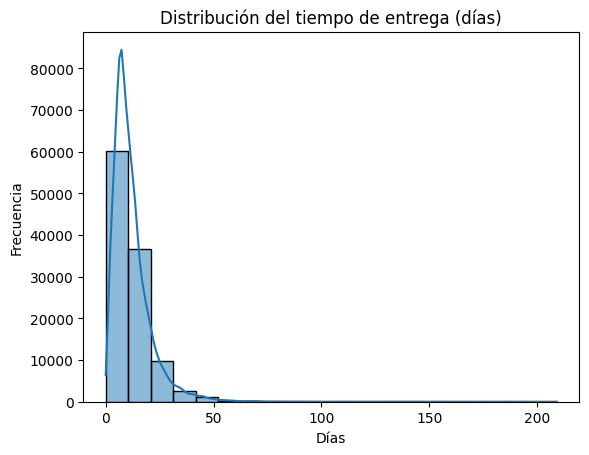

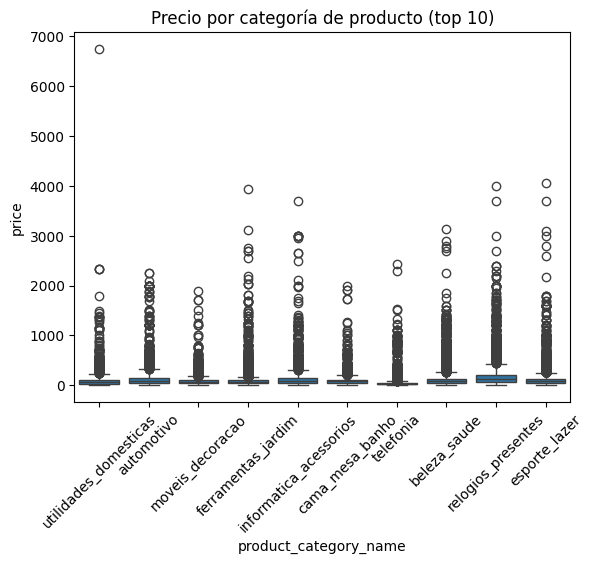

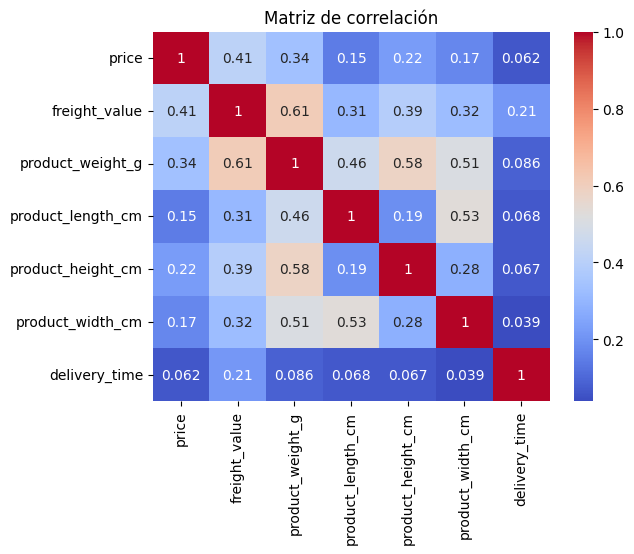

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Resumen estadístico
print(df.describe())

# Histograma del tiempo de entrega
sns.histplot(df['delivery_time'].dropna(), bins=20, kde=True)
plt.title("Distribución del tiempo de entrega (días)")
plt.xlabel("Días")
plt.ylabel("Frecuencia")
plt.show()

# Boxplot del precio por categoría
top_cats = df['product_category_name'].value_counts().head(10).index
sns.boxplot(data=df[df['product_category_name'].isin(top_cats)],
            x='product_category_name', y='price')
plt.xticks(rotation=45)
plt.title("Precio por categoría de producto (top 10)")
plt.show()

# Matriz de correlación
num_vars = ['price', 'freight_value', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'delivery_time']
corr = df[num_vars].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.title("Matriz de correlación")
plt.show()

### Preprocesamiento del Dataset

In [11]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
)

# ======== 1. PREPROCESAMIENTO GENERAL ========
df_model = df.dropna(subset=[
    'price', 'delivery_time', 'review_score', 'product_category_name',
    'freight_value', 'product_weight_g', 'product_length_cm',
    'product_height_cm', 'product_width_cm'
]).copy()

# Codificación
le = LabelEncoder()
df_model['product_category_encoded'] = le.fit_transform(df_model['product_category_name'])
df_model['satisfaccion'] = df_model['review_score'].apply(lambda x: 1 if x >= 4 else 0)

features = ['price', 'freight_value', 'product_weight_g', 'product_length_cm',
            'product_height_cm', 'product_width_cm', 'product_category_encoded']

X = df_model[features]
y_reg = df_model['delivery_time']
y_clf = df_model['satisfaccion']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg, test_size=0.2, random_state=42)
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X, y_clf, test_size=0.2, random_state=42)

# ======== 2. REGRESIÓN ========
X_train_sample = X_train_reg.sample(3000, random_state=42)
y_train_sample = y_train_reg.loc[X_train_sample.index]

models_reg = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=50, random_state=42)
}

print("REGRESIÓN")
for name, model in models_reg.items():
    model.fit(X_train_sample, y_train_sample)
    y_pred = model.predict(X_test_reg)

    print(f"\n {name}")
    print("MAE:", round(mean_absolute_error(y_test_reg, y_pred), 2))
    print("RMSE:", round(np.sqrt(mean_squared_error(y_test_reg, y_pred)), 2))
    print("R²:", round(r2_score(y_test_reg, y_pred), 4))

# ======== 3. CLASIFICACIÓN ========
X_train_clf_sample = X_train_clf.sample(5000, random_state=42)
y_train_clf_sample = y_train_clf.loc[X_train_clf_sample.index]

X_test_clf = X_test_clf.dropna()
y_test_clf = y_test_clf.loc[X_test_clf.index]

models_clf = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42)
}

print("\nCLASIFICACIÓN")
for name, model in models_clf.items():
    model.fit(X_train_clf_sample, y_train_clf_sample)
    y_pred = model.predict(X_test_clf)

    print(f"\n {name}")
    print("Accuracy:", round(accuracy_score(y_test_clf, y_pred), 4))
    print("Precision:", round(precision_score(y_test_clf, y_pred), 4))
    print("Recall:", round(recall_score(y_test_clf, y_pred), 4))
    print("F1-score:", round(f1_score(y_test_clf, y_pred), 4))
    print("Confusion Matrix:\n", confusion_matrix(y_test_clf, y_pred))


REGRESIÓN

 Linear Regression
MAE: 6.01
RMSE: 8.94
R²: 0.0479

 Random Forest
MAE: 5.83
RMSE: 8.87
R²: 0.0624

CLASIFICACIÓN

 Logistic Regression
Accuracy: 0.7679
Precision: 0.7685
Recall: 0.999
F1-score: 0.8687
Confusion Matrix:
 [[    2  5019]
 [   16 16659]]

 Random Forest
Accuracy: 0.7464
Precision: 0.7781
Recall: 0.9373
F1-score: 0.8503
Confusion Matrix:
 [[  563  4458]
 [ 1045 15630]]


### Exportar el dataset preprocesado

In [12]:
df_model.to_csv("olist_dataset_modelado.csv", index=False)
print("Dataset exportado exitosamente como 'olist_dataset_modelado.csv'")

Dataset exportado exitosamente como 'olist_dataset_modelado.csv'


### MODELOS DE REGRESIÓN

Regresión Simple

Regresión Lineal Simple
Coeficiente (pendiente): 0.128269898043979
Intercepto: 9.404819025303238
MAE: 6.09
RMSE: 9.13
R²: 0.0464


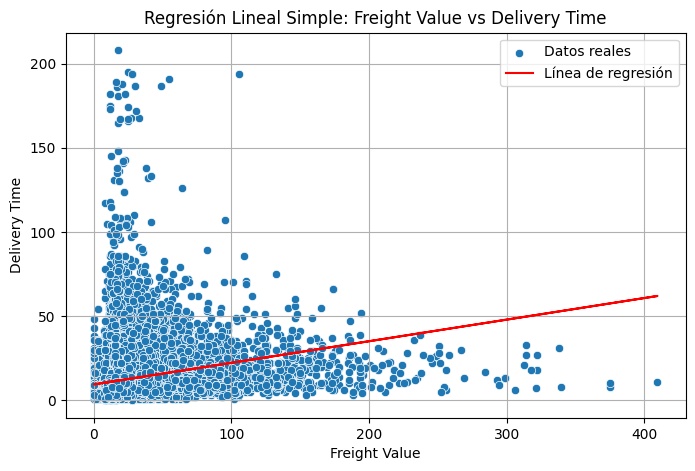

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Datos
x_simple = df_model[['freight_value']]
y_simple = df_model['delivery_time']

# Entrenamiento
model_simple = LinearRegression()
model_simple.fit(x_simple, y_simple)

# Predicción
y_pred_simple = model_simple.predict(x_simple)

# Métricas
print("Regresión Lineal Simple")
print("Coeficiente (pendiente):", model_simple.coef_[0])
print("Intercepto:", model_simple.intercept_)
print("MAE:", round(mean_absolute_error(y_simple, y_pred_simple), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_simple, y_pred_simple)), 2))  
print("R²:", round(r2_score(y_simple, y_pred_simple), 4))
plt.figure(figsize=(8,5))
sns.scatterplot(x=x_simple['freight_value'], y=y_simple, label='Datos reales')
plt.plot(x_simple, y_pred_simple, color='red', label='Línea de regresión')
plt.xlabel('Freight Value')
plt.ylabel('Delivery Time')
plt.title('Regresión Lineal Simple: Freight Value vs Delivery Time')
plt.legend()
plt.grid(True)
plt.show()

Aunque la línea de regresión sube un poco (es decir, hay una ligera relación positiva entre el costo de envío y el tiempo de entrega), la dispersión de los puntos es enorme. Eso quiere decir que el valor del transporte por sí solo no explica muy bien cuánto se va a tardar en llegar un pedido.
El R² es de apenas 0.046, o sea, la línea apenas explica el 4.6% del comportamiento real. En resumen, sí hay una tendencia, pero es tan débil que no podemos confiar mucho solo en este dato.

Regresión múltiple

Regresión Lineal Múltiple
MAE: 6.05
RMSE: 9.11
R²: 0.0515


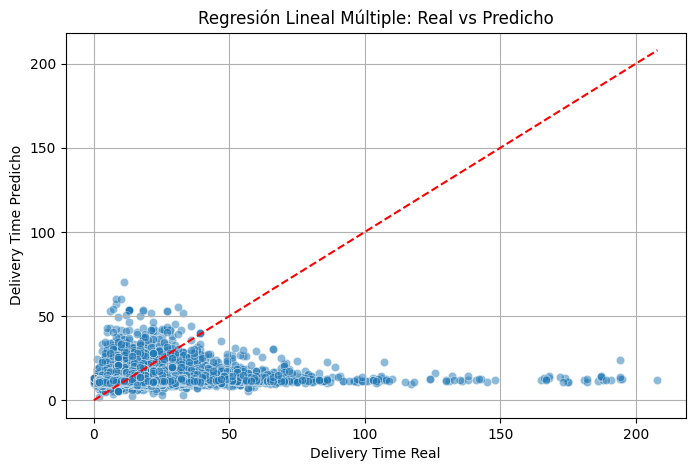

In [14]:
X_multi = df_model[['price', 'freight_value', 'product_weight_g',
                    'product_length_cm', 'product_height_cm',
                    'product_width_cm', 'product_category_encoded']]
y_multi = df_model['delivery_time']

# Modelo
model_multi = LinearRegression()
model_multi.fit(X_multi, y_multi)

# Predicción
y_pred_multi = model_multi.predict(X_multi)

# Métricas
print("Regresión Lineal Múltiple")
print("MAE:", round(mean_absolute_error(y_multi, y_pred_multi), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_multi, y_pred_multi)), 2))
print("R²:", round(r2_score(y_multi, y_pred_multi), 4))
plt.figure(figsize=(8,5))
sns.scatterplot(x=y_multi, y=y_pred_multi, alpha=0.5)
plt.plot([y_multi.min(), y_multi.max()], [y_multi.min(), y_multi.max()], 'r--')
plt.xlabel("Delivery Time Real")
plt.ylabel("Delivery Time Predicho")
plt.title("Regresión Lineal Múltiple: Real vs Predicho")
plt.grid(True)
plt.show()


Aquí ya usamos varias variables para predecir el tiempo de entrega, y aunque el modelo mejoró apenas un poco comparado con la regresión simple (el R2 subió a 0.0515, o sea, ahora explica el 5.1% del total), todavía le cuesta bastante predecir con precisión.  
La nube de puntos está bastante dispersa y muchos valores están lejos de la línea punteada ideal. En resumen, usar más variables sí ayudó pero no es suficiente. Probablemente hay factores fuera del dataset que están influyendo mucho más (como logística, zona de entrega, tráfico, etc).


Regresión polinomial


Regresión Polinomial (grado 2)
Coeficientes: [ 5.99063235e-03 -1.71525401e-06]
Intercepto: 11.328725049521395
MAE: 6.29
RMSE: 9.32
R²: 0.0057


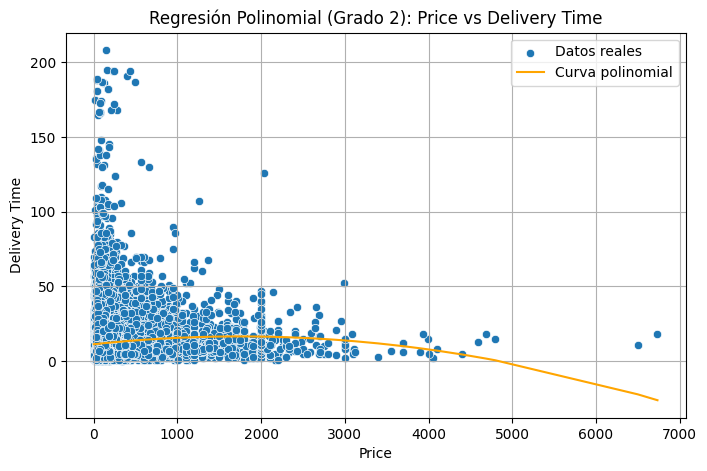

In [15]:
from sklearn.preprocessing import PolynomialFeatures

# Variable base
X_poly_base = df_model[['price']]
y_poly = df_model['delivery_time']

# Transformación polinomial de grado 2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_poly_base)

# Modelo
model_poly = LinearRegression()
model_poly.fit(X_poly, y_poly)

# Predicción
y_pred_poly = model_poly.predict(X_poly)

# Métricas
print("Regresión Polinomial (grado 2)")
print("Coeficientes:", model_poly.coef_)
print("Intercepto:", model_poly.intercept_)
print("MAE:", round(mean_absolute_error(y_poly, y_pred_poly), 2))
print("RMSE:", round(np.sqrt(mean_squared_error(y_poly, y_pred_poly)), 2))
print("R²:", round(r2_score(y_poly, y_pred_poly), 4))

plt.figure(figsize=(8,5))
sorted_idx = X_poly_base['price'].argsort()
x_sorted = X_poly_base['price'].iloc[sorted_idx]
y_sorted = y_pred_poly[sorted_idx]

sns.scatterplot(x=X_poly_base['price'], y=y_poly, label='Datos reales')
plt.plot(x_sorted, y_sorted, color='orange', label='Curva polinomial')
plt.xlabel('Price')
plt.ylabel('Delivery Time')
plt.title('Regresión Polinomial (Grado 2): Price vs Delivery Time')
plt.legend()
plt.grid(True)
plt.show()


Aquí intentamos ajustar una curva en lugar de una línea, para ver si el precio del producto se relaciona de forma no lineal con el tiempo de entrega. Visualmente la curva se ve más “ajustada” que una recta, pero la verdad es que el modelo sigue sin capturar bien la realidad.
El R² es bajísimo (0.0057), lo que quiere decir que la relación entre el precio del producto y el tiempo de entrega prácticamente no existe o no es útil para predecir.

## Pipeline

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Cargar el dataset correcto
df_model = pd.read_csv('olist_dataset_modelado.csv')

# Revisar columnas disponibles
df_model.head()

# Variables predictoras y variable objetivo
X = df_model[['price', 'freight_value', 'product_weight_g',
              'product_length_cm', 'product_height_cm',
              'product_width_cm', 'product_category_encoded']]
y = df_model['delivery_time']

# División entre entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Escalado de datos
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Confirmar tamaños de los datos
print("Shape de X_train:", X_train_scaled.shape)
print("Shape de X_test:", X_test_scaled.shape)


Shape de X_train: (86782, 7)
Shape de X_test: (21696, 7)


## Metricas

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


# Lista para guardar resultados
resultados = []

# Regresión Lineal Simple
mae_simple = mean_absolute_error(y_simple, y_pred_simple)
rmse_simple = np.sqrt(mean_squared_error(y_simple, y_pred_simple))
r2_simple = r2_score(y_simple, y_pred_simple)

resultados.append({
    'Modelo': 'Regresión Lineal Simple',
    'MAE': round(mae_simple, 2),
    'RMSE': round(rmse_simple, 2),
    'R²': round(r2_simple, 4)
})

# Regresión Lineal Múltiple
mae_multi = mean_absolute_error(y_multi, y_pred_multi)
rmse_multi = np.sqrt(mean_squared_error(y_multi, y_pred_multi))
r2_multi = r2_score(y_multi, y_pred_multi)

resultados.append({
    'Modelo': 'Regresión Lineal Múltiple',
    'MAE': round(mae_multi, 2),
    'RMSE': round(rmse_multi, 2),
    'R²': round(r2_multi, 4)
})

# Regresión Polinomial
mae_poly = mean_absolute_error(y_poly, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_poly, y_pred_poly))
r2_poly = r2_score(y_poly, y_pred_poly)

resultados.append({
    'Modelo': 'Regresión Polinomial (Grado 2)',
    'MAE': round(mae_poly, 2),
    'RMSE': round(rmse_poly, 2),
    'R²': round(r2_poly, 4)
})

# Regresión con Árbol de Decisión
# Entrenamiento
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Predicción
y_pred_dt = dt_model.predict(X_test)

# Métricas
mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))
r2_dt = r2_score(y_test, y_pred_dt)

resultados.append({
    'Modelo': 'Regresión Árbol de Decisión',
    'MAE': round(mae_dt, 2),
    'RMSE': round(rmse_dt, 2),
    'R²': round(r2_dt, 4)
})

# 2. Regresión Random Forest
# Entrenamiento
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predicción
y_pred_rf = rf_model.predict(X_test)

# Métricas
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

resultados.append({
    'Modelo': 'Regresión Random Forest',
    'MAE': round(mae_rf, 2),
    'RMSE': round(rmse_rf, 2),
    'R²': round(r2_rf, 4)
})

# 3. Regresión SVR (Support Vector Regression)
# Entrenamiento
svr_model = SVR(kernel='rbf')
svr_model.fit(X_train, y_train)

# Predicción
y_pred_svr = svr_model.predict(X_test)

# Métricas
mae_svr = mean_absolute_error(y_test, y_pred_svr)
rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

resultados.append({
    'Modelo': 'Regresión SVR',
    'MAE': round(mae_svr, 2),
    'RMSE': round(rmse_svr, 2),
    'R²': round(r2_svr, 4)
})


# Mostrar todo como tabla
df_resultados = pd.DataFrame(resultados)
df_resultados


,Modelo,MAE,RMSE,R²
0,Regresión Lineal Simple,6.09,9.13,0.0464
1,Regresión Lineal Múltiple,6.05,9.11,0.0515
2,Regresión Polinomial (Grado 2),6.29,9.32,0.0057
